In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install fastapi
!pip install uvicorn
!pip install nest_asyncio
!pip install python-multipart
import nest_asyncio
nest_asyncio.apply()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.1 MB/s eta 0:00:00


In [3]:
!pip install flask-ngrok

In [4]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 40.5 MB/s eta 0:00:00


In [5]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [6]:
%load_ext tensorboard

In [7]:
import os
import torch
import shutil
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from torchmetrics import MeanAbsoluteError

In [8]:
# 데이터 경로 설정
data_path = "/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/final_preprocessed_format.csv"

# 데이터 로드
df_total = pd.read_csv(data_path)

# 스케일링
scaler = MinMaxScaler()
df_total['feed_pressure'] = scaler.fit_transform(df_total[['feed_pressure']])

# 시간 인덱스 추가 (필요하다면 데이터셋에 이미 포함되어 있는 time_idx 확인)
if 'time_idx' not in df_total.columns:
    df_total['time_idx'] = range(len(df_total))

# 그룹 ID 설정 (단일 시계열일 경우 고정값 사용)
if 'group' not in df_total.columns:
    df_total["group"] = "series"

# max_encoder_length와 max_prediction_length 설정
total_data_length = len(df_total)
max_encoder_length = max(10, total_data_length // 100)
max_prediction_length = 1

print(f"Max encoder length: {max_encoder_length} entries")
print(f"Max prediction length: {max_prediction_length} entries")

Max encoder length: 559 entries
Max prediction length: 1 entries


### TimeSeriesDataSet 생성
TimeSeriesDataSet을 사용해 데이터를 생성합니다. 여기에는 타겟, 그룹화 방식, 그리고 변동하는 시계열 컬럼을 정의합니다.


In [9]:
# 학습 및 검증 데이터 분할 (80% 학습, 20% 검증)
train_size = int(total_data_length * 0.8)
df_train = df_total.iloc[:train_size]
df_val = df_total.iloc[train_size:]

# TimeSeriesDataSet 설정
training = TimeSeriesDataSet(
    df_train,  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",  # 타겟 변수
    group_ids=["group"],  # 그룹화
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 관련 변수
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

# 검증 데이터셋 생성
validation = TimeSeriesDataSet.from_dataset(training, df_val)

### DataLoader 생성
DataLoader를 생성하여 모델이 데이터를 학습할 수 있도록 준비합니다.

### Temporal Fusion Transformer 모델 생성
Temporal Fusion Transformer 모델을 생성하여 데이터셋을 학습할 준비를 합니다.

### LightningModule 정의 및 Trainer 설정
PyTorch Lightning을 이용하여 모델 학습을 보다 쉽게 관리할 수 있도록 합니다.


In [113]:
best_params = {
    "hidden_size": 45,
    "attention_head_size": 1,
    "dropout": 0.2780334372377269,
    "learning_rate": 0.001982480242982696,
    "hidden_continuous_size": 26
}

In [114]:
# 데이터 로더 생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=32, num_workers=0)

from torchmetrics import MeanAbsoluteError

# Define the loss function
loss = MeanAbsoluteError()

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=best_params["learning_rate"],
    hidden_size=best_params["hidden_size"],
    attention_head_size=best_params["attention_head_size"],
    dropout=best_params["dropout"],
    hidden_continuous_size=best_params.get("hidden_continuous_size", 16),
    loss=loss,
    log_interval=10,
    reduce_on_plateau_patience=5,
    optimizer="adam"
)

In [115]:
# TFTWrapper
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model, hparams=None):
        super().__init__()
        self.tft_model = tft_model

        # 하이퍼파라미터 저장
        if hparams is None:
            hparams = {
                "learning_rate": 0.001982480242982696,
                "hidden_size": 45,
                "attention_head_size": 1,
                "dropout": 0.2780334372377269,
                "hidden_continuous_size": 26,
                "output_size": 1,
                "max_encoder_length": 559,
                "log_interval": 10,
                "reduce_on_plateau_patience": 5,
            }
        self.save_hyperparameters(hparams)  # 하이퍼파라미터 저장

    def forward(self, x):
        # 모든 입력 데이터를 모델의 디바이스로 이동
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        self.tft_model.to(device)  # 모델 디바이스로 이동
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        y = y[0] if isinstance(y, tuple) else y
        y = y.to(device)

        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        y = y[0] if isinstance(y, tuple) else y
        y = y.to(device)

        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams["learning_rate"])
        lr_scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            "monitor": "val_loss",
        }
        return [optimizer], [lr_scheduler]

In [116]:
# Google Drive에 저장된 체크포인트 경로
checkpoint_path = "/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt"

# 모델 학습 및 체크포인트 설정
local_checkpoint_dir = "/content/checkpoints/"
drive_checkpoint_dir = "/content/drive/MyDrive/종설프1_5팀/checkpoints/"
os.makedirs(local_checkpoint_dir, exist_ok=True)
os.makedirs(drive_checkpoint_dir, exist_ok=True)

# 기존 체크폰트 파일 삭제 함수
def delete_existing_checkpoints(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        for filename in os.listdir(checkpoint_dir):
            file_path = os.path.join(checkpoint_dir, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    print(f"Deleted checkpoint file: {file_path}")
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")


# 가장 최근 체크포인트 찾기
def get_latest_checkpoint(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        checkpoints = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]
        if checkpoints:
            return max(checkpoints, key=os.path.getctime)  # 가장 최근 파일 반환
    return None

### Optuna 활용

In [ ]:
def objective(trial):
    # 하이퍼파라미터 정의
    hidden_size = trial.suggest_int("hidden_size", 8, 64)
    attention_head_size = trial.suggest_int("attention_head_size", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    hidden_continuous_size = trial.suggest_int("hidden_continuous_size", 8, 32)

    # TemporalFusionTransformer 모델 생성
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        hidden_continuous_size=hidden_continuous_size,
        loss=loss,
        log_interval=10,
        reduce_on_plateau_patience=3
    )

    # LightningModule로 감싸기
    wrapped_tft = TFTWrapper(tft)

    # EarlyStopping 설정
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=3,
        verbose=True,
        mode="min"
    )

    # Checkpoint 콜백 설정
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        dirpath=f"{local_checkpoint_dir}/trial_{trial.number}",
        filename="tft-{epoch:02d}-{val_loss:.2f}"
    )

    # Logger 설정
    logger = TensorBoardLogger("lightning_logs", name=f"optuna_trial_{trial.number}")

    # Trainer 설정
    trainer = Trainer(
        max_epochs=10,
        accelerator="gpu",
        devices=1,
        callbacks=[checkpoint_callback, early_stop_callback],
        logger=logger
    )

    # 모델 학습
    trainer.fit(
        model=wrapped_tft,  # LightningModule로 감싼 모델 사용
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

    # 검증 손실 반환
    val_loss = trainer.callback_metrics.get("val_loss", None)
    if val_loss is None:
        raise ValueError("Validation loss is not available.")
    return val_loss.item()

In [37]:
# 2. Optuna 스터디 생성
study = optuna.create_study(direction="minimize")

# 3. 최적화 실행
study.optimize(objective, n_trials=3)

# 4. 최적화 결과 사용
best_params = study.best_params

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=best_params["learning_rate"],
    hidden_size=best_params["hidden_size"],
    attention_head_size=best_params["attention_head_size"],
    dropout=best_params["dropout"],
    hidden_continuous_size=best_params["hidden_continuous_size"],  # 최적화된 값 반영
    loss=loss,
    log_interval=10,
    reduce_on_plateau_patience=5
)

[I 2024-12-10 15:19:23,868] A new study created in memory with name: no-name-f68ad1ef-f798-40cc-b243-22fed6b09ae3


NameError: name 'objective' is not defined

In [32]:
print(study.best_params)

NameError: name 'study' is not defined

## 모델 학습

<span style="color:red;">주의: 체크포인트 삭제!</span>

In [118]:
# LightningModule로 감싸기
wrapped_tft = TFTWrapper(tft).to("cuda")  # GPU로 이동

# Trainer 설정
trainer = Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            dirpath=local_checkpoint_dir,
            filename="tft-best",
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            save_last=True
        ),
        EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=10,
            verbose=True,
            mode="min"
        )
    ],
    logger=TensorBoardLogger("lightning_logs", name="tft_final"),
    gradient_clip_val=0.3,
    precision=32,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [119]:
# 기존 체크포인트에서 로드 여부 확인 및 학습 실행
delete_checkpoints = input("기존 체크포인트 파일을 삭제하시겠습니까? (y/n): ").lower()

if delete_checkpoints == 'y':
    print("기존 체크포인트 파일을 삭제합니다.")
    delete_existing_checkpoints(local_checkpoint_dir)
    delete_existing_checkpoints(drive_checkpoint_dir)

    # 새 학습 시작
    trainer.fit(
        model=wrapped_tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

else:
    print("기존 체크포인트를 유지합니다.")
    latest_checkpoint = get_latest_checkpoint(local_checkpoint_dir)

    if latest_checkpoint:
        print(f"기존 체크포인트에서 로드합니다: {latest_checkpoint}")

        # 체크포인트에서 모델 로드
        loaded_tft = TemporalFusionTransformer.load_from_checkpoint(
            latest_checkpoint,
            map_location=torch.device('cuda')
        )

        # TFTWrapper로 래핑 및 GPU로 이동
        wrapped_tft = TFTWrapper(tft_model=loaded_tft).to('cuda')

        # 기존 체크포인트에서 로드한 모델로 학습 재개
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )

    else:
        print("체크포인트가 없습니다. 새로 학습을 시작합니다.")

        # 새 학습 시작
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )

기존 체크포인트 파일을 삭제하시겠습니까? (y/n): y


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 118 K  | train
----------------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.475     Total estimated model params size (MB)
172       Modules in train mode
0         Modules in eval mode


기존 체크포인트 파일을 삭제합니다.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.011. Signaling Trainer to stop.


In [120]:
# 학습 종료 후 가장 좋은 체크포인트 경로 출력
print(f"Best checkpoint saved at: {checkpoint_callback.best_model_path}")

Best checkpoint saved at: /content/checkpoints/tft-epoch=16-val_loss=0.06.ckpt


In [93]:
# 학습 종료 후 가장 좋은 체크포인트 경로 출력
best_checkpoint_path = checkpoint_callback.best_model_path

if best_checkpoint_path and os.path.exists(best_checkpoint_path):
    print(f"Best checkpoint saved at: {best_checkpoint_path}")

    # 학습이 끝난 후 로컬 체크포인트를 Google Drive로 복사
    shutil.copyfile(
        best_checkpoint_path,
        os.path.join(drive_checkpoint_dir, os.path.basename(best_checkpoint_path))
    )
    print(f"Best checkpoint copied to Google Drive at: {drive_checkpoint_dir}")
else:
    print("No valid checkpoint found to copy. Please check if training completed successfully.")


Best checkpoint saved at: /content/checkpoints/tft-epoch=16-val_loss=0.06.ckpt
Best checkpoint copied to Google Drive at: /content/drive/MyDrive/종설프1_5팀/checkpoints/


In [121]:
# 학습이 끝난 후 로컬 체크포인트를 Google Drive로 복사
shutil.copyfile(
    os.path.join(local_checkpoint_dir, "tft-best.ckpt"),
    os.path.join(drive_checkpoint_dir, "tft-best.ckpt")
)

'/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt'

## 서버구축

In [14]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2024-12-10 14:54:29--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.71.179.82, 99.83.220.108, 75.2.60.68, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.71.179.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  4.70MB/s    in 2.8s    

2024-12-10 14:54:33 (4.70 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [15]:
!./ngrok authtoken cr_2pQNo2X1zqJCJbgu2vzvGoq8ubY

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## 모델 다시 로드

In [137]:
# Google Drive에 저장된 체크포인트 경로
checkpoint_path = "/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt"

loaded_tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=best_params["learning_rate"],
    hidden_size=best_params["hidden_size"],
    attention_head_size=best_params["attention_head_size"],
    dropout=best_params["dropout"],
    hidden_continuous_size=best_params["hidden_continuous_size"],  # 최적화된 값 반영
    loss=loss,
    log_interval=10,
    reduce_on_plateau_patience=5
)

# 체크포인트 로드
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))  # GPU로 로드

# state_dict 키 이름 수정
state_dict = checkpoint["state_dict"]
new_state_dict = {k.replace("tft_model.", ""): v for k, v in state_dict.items()}  # 접두사 제거

# 수정된 state_dict를 모델에 로드
loaded_tft.load_state_dict(new_state_dict)
loaded_tft.to('cuda')  # GPU로 이동
loaded_tft.eval()

<ipython-input-137-4656aa22faa7>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))  # GPU로 로드


TemporalFusionTransformer(
  	"attention_head_size":               1
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'feed_pressure', 'group_ids': ['group'], 'weight': None, 'max_encoder_length': 559, 'min_encoder_length': 559, 'min_prediction_idx': 0, 'min_prediction_length': 1, 'max_prediction_length': 1, 'static_categoricals': [], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['time_idx'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['feed_pressure'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': False, 'lags': None, 'add_relative_time_idx': False, 'add_target_scales': False, 'add_encoder_length': False, 'target_normalizer': GroupNormalizer(
  		method='standard',
  		groups=None,
  		center=True,
  		scale_by_group=False,
  		transformation='relu',
  		method

## ROLLING 방식

In [138]:
# 'group' 컬럼 확인 및 추가
if "group" not in df_total.columns or df_total["group"].isnull().any():
    print("'group' 컬럼이 누락되었거나 비어 있습니다. 기본 그룹 값을 설정합니다.")
    df_total["group"] = "series"  # 기본 그룹 값 설정

In [139]:
# 'group' 컬럼 고유성 확인
if df_total["group"].nunique() > 1:
    print(f"'group' 컬럼에 {df_total['group'].nunique()}개의 고유 값이 있습니다. 모델이 단일 그룹을 예상할 수 있으니 확인하세요.")

# Rolling Prediction 실행 전에 데이터 유효성 확인
if len(df_total) < max_encoder_length:
    print(
        f"데이터셋 길이 ({len(df_total)})가 max_encoder_length ({max_encoder_length})보다 짧습니다. "
        "데이터를 패딩하여 문제를 해결합니다."
    )
    # 필요한 패딩 길이 계산
    padding_length = max_encoder_length - len(df_total)
    last_row = df_total.iloc[-1]
    padding = pd.DataFrame([last_row] * padding_length)

    # time_idx를 늘리기
    padding["time_idx"] = range(df_total["time_idx"].max() + 1, df_total["time_idx"].max() + 1 + padding_length)

    # 패딩 추가
    df_total = pd.concat([df_total, padding], ignore_index=True)
    print(f"데이터셋이 {len(df_total)}로 패딩되었습니다.")


In [140]:
def rolling_predict_until_condition(
    model, train_dataset, max_encoder_length, scaler, condition_value=17, tolerance=0.1, device="cuda"
):
    """
    Rolling 방식으로 train의 첫 max_encoder_length 데이터를 바탕으로 조건 만족 시까지 예측합니다.

    Args:
        model: PyTorch 모델.
        train_dataset: 학습에 사용된 데이터셋 (DataFrame 형태).
        max_encoder_length: 롤링 윈도우의 길이.
        scaler: MinMaxScaler (스케일링 복원을 위해 필요).
        condition_value: 예측이 중단되는 조건 값 (예: 17).
        tolerance: 조건 값에 대한 허용 오차.
        device: 사용할 디바이스 (default: "cuda").

    Returns:
        predictions (list): 예측된 값의 리스트.
    """
    model = model.to(device)
    model.eval()

    # Initialize with the first encoder window from the training data
    input_data = train_dataset.iloc[:max_encoder_length].copy()
    predictions = []

    # Add group column if missing
    if "group" not in input_data.columns:
        input_data["group"] = "series"

    step = 0
    while True:
        try:
            # Create TimeSeriesDataSet for rolling prediction
            rolling_dataset = TimeSeriesDataSet(
                data=input_data,
                time_idx="time_idx",
                target="feed_pressure",
                group_ids=["group"],
                max_encoder_length=max_encoder_length,
                max_prediction_length=1,
                static_categoricals=[],
                time_varying_known_reals=["time_idx"],
                time_varying_unknown_reals=["feed_pressure"],
                target_normalizer=GroupNormalizer(transformation="relu"),
                min_encoder_length=1,
                allow_missing_timesteps=True,
            )

            rolling_dataloader = rolling_dataset.to_dataloader(train=False, batch_size=1)

            # Predict the next value
            with torch.no_grad():
                input_batch = next(iter(rolling_dataloader))
                input_batch = {key: value.to(device) for key, value in input_batch[0].items()}
                prediction = model(input_batch)["prediction"].cpu().numpy().squeeze()

            # Restore the scaled prediction to original scale
            prediction_actual = scaler.inverse_transform([[prediction]]).flatten()[0]
            predictions.append(prediction_actual)

            print(f"Step {step}: Predicted Value = {prediction_actual}")

            # Check if the condition is met
            if abs(prediction_actual - condition_value) <= tolerance:
                print(f"Condition met: Predicted value is within tolerance of {condition_value}. Stopping prediction.")
                break

            # Update rolling input data with new predicted value
            new_time_idx = input_data["time_idx"].iloc[-1] + 1
            new_row = {
                "time_idx": new_time_idx,
                "feed_pressure": float(prediction),
                "group": "series",
            }
            input_data = pd.concat([input_data.iloc[1:], pd.DataFrame([new_row])], ignore_index=True)

            step += 1

        except Exception as e:
            print(f"Error at step {step}: {e}")
            break

    return predictions


In [141]:

rolling_predictions = rolling_predict_until_condition(
    model=wrapped_tft,
    train_dataset=df_train,
    max_encoder_length=max_encoder_length,
    scaler=scaler,
    condition_value=17,
    tolerance=0.1,
    device="cuda",
)



Step 0: Predicted Value = 9.568602508787066
Step 1: Predicted Value = 9.570302404012532
Step 2: Predicted Value = 9.571956515690312
Step 3: Predicted Value = 9.573522402137518
Step 4: Predicted Value = 9.575004741964861
Step 5: Predicted Value = 9.57639350957796
Step 6: Predicted Value = 9.577575749946758
Step 7: Predicted Value = 9.57846524295956
Step 8: Predicted Value = 9.57910509867221
Step 9: Predicted Value = 9.579523500144482
Step 10: Predicted Value = 9.579775476749987
Step 11: Predicted Value = 9.58106120353192
Step 12: Predicted Value = 9.582853779807687
Step 13: Predicted Value = 9.58476722019352
Step 14: Predicted Value = 9.586521922001616
Step 15: Predicted Value = 9.587902223557233
Step 16: Predicted Value = 9.58958128782548
Step 17: Predicted Value = 9.591401044601575
Step 18: Predicted Value = 9.593285744950174
Step 19: Predicted Value = 9.595200410686433
Step 20: Predicted Value = 9.597104493850843
Step 21: Predicted Value = 9.598962459281086
Step 22: Predicted Value =

KeyboardInterrupt: 

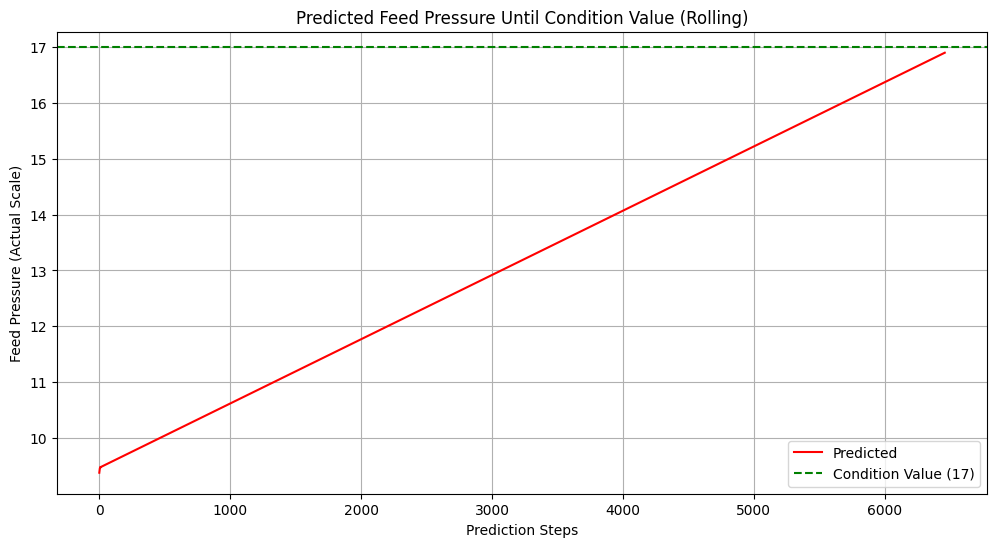

In [127]:
# 결과 시각화 함수
def plot_rolling_predictions(predicted_values, condition_value=17):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(predicted_values)), predicted_values, label="Predicted", linestyle="-", color="red")
    plt.axhline(y=condition_value, color="green", linestyle="--", label=f"Condition Value ({condition_value})")
    plt.xlabel("Prediction Steps")
    plt.ylabel("Feed Pressure (Actual Scale)")
    plt.title("Predicted Feed Pressure Until Condition Value (Rolling)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Rolling Predictions 그래프 호출
plot_rolling_predictions(rolling_predictions, condition_value=17)


###  Api System

In [53]:
from fastapi import FastAPI, File, UploadFile
import pandas as pd
import torch
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss
from sklearn.preprocessing import MinMaxScaler

app = FastAPI()

# 기존 모델 로딩 코드
checkpoint_path = "/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))

hparams = checkpoint.get("hyper_parameters")
state_dict = checkpoint["state_dict"]

model = TemporalFusionTransformer(
    learning_rate=hparams["learning_rate"],
    hidden_size=hparams["hidden_size"],
    attention_head_size=hparams["attention_head_size"],
    dropout=hparams["dropout"],
    hidden_continuous_size=hparams["hidden_continuous_size"],
    loss=QuantileLoss(),
    log_interval=hparams["log_interval"],
    reduce_on_plateau_patience=hparams["reduce_on_plateau_patience"],
    output_size=hparams["output_size"],
    max_encoder_length=hparams["max_encoder_length"],
)
model.load_state_dict(state_dict, strict=False)
model.to("cuda")
model.eval()

# Rolling Prediction 함수
def rolling_predict_batch(model, train_dataset, max_encoder_length, scaler, condition_value=17, tolerance=0.1, smoothing_factor=0.5, device="cuda"):
    model.eval()
    input_data = train_dataset.iloc[:max_encoder_length].copy()
    predictions = []

    if "group" not in input_data.columns:
        input_data["group"] = "series"

    while True:
        try:
            rolling_dataset = TimeSeriesDataSet(
                data=input_data,
                time_idx="time_idx",
                target="feed_pressure",
                group_ids=["group"],
                max_encoder_length=max_encoder_length,
                max_prediction_length=1,
                static_categoricals=[],
                time_varying_known_reals=["time_idx"],
                time_varying_unknown_reals=["feed_pressure"],
                target_normalizer=None,
                allow_missing_timesteps=True,
            )
            rolling_dataloader = rolling_dataset.to_dataloader(train=False, batch_size=1)
            input_batch = next(iter(rolling_dataloader))
            with torch.no_grad():
                batch_predictions = model(input_batch)["prediction"].cpu().numpy().squeeze()

            batch_predictions_actual = scaler.inverse_transform(batch_predictions.reshape(-1, 1)).flatten()
            current_prediction = batch_predictions_actual[0]
            predictions.append(current_prediction)

            if abs(current_prediction - condition_value) <= tolerance:
                break

            new_row = {
                "time_idx": input_data["time_idx"].iloc[-1] + 1,
                "feed_pressure": current_prediction,
                "group": "series",
            }
            input_data = pd.concat([input_data.iloc[1:], pd.DataFrame([new_row])], ignore_index=True)
        except Exception as e:
            print(f"Error during rolling prediction: {e}")
            break

    return predictions

@app.post("/process")
async def process_file(file: UploadFile = File(...)):
    """
    Processes the uploaded file and returns predictions.
    """
    try:
        # Read the uploaded file
        content = await file.read()
        df = pd.read_csv(pd.compat.StringIO(content.decode('utf-8')))

        # Data preprocessing
        scaler = MinMaxScaler()
        df["feed_pressure"] = scaler.fit_transform(df[["feed_pressure"]])
        df["time_idx"] = range(len(df))

        # Rolling predictions
        predictions = rolling_predict_batch(
            model=model,
            train_dataset=df,
            max_encoder_length=hparams["max_encoder_length"],
            scaler=scaler,
            condition_value=17,
            tolerance=0.1,
            smoothing_factor=0.5,
            device="cuda",
        )

        return {"predictions": predictions}
    except Exception as e:
        return {"error": str(e)}

# FastAPI 서버 실행
if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)


<ipython-input-53-a14c915fa448>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))
INFO:     Start

In [145]:
import pandas as pd
import torch
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss
from sklearn.preprocessing import MinMaxScaler

# 모델 체크포인트 로드
checkpoint_path = "/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cuda"))

# Hyperparameters 및 state_dict 가져오기
hparams = checkpoint.get("hyper_parameters")
state_dict = checkpoint["state_dict"]

# TemporalFusionTransformer 수동 초기화
loaded_tft = TemporalFusionTransformer(
    learning_rate=hparams["learning_rate"],
    hidden_size=hparams["hidden_size"],
    attention_head_size=hparams["attention_head_size"],
    dropout=hparams["dropout"],
    hidden_continuous_size=hparams["hidden_continuous_size"],
    loss=QuantileLoss(),
    log_interval=hparams["log_interval"],
    reduce_on_plateau_patience=hparams["reduce_on_plateau_patience"],
    output_size=hparams["output_size"],
    max_encoder_length=hparams["max_encoder_length"],
)

# state_dict 로드
loaded_tft.load_state_dict(state_dict, strict=False)
loaded_tft.to("cuda")
loaded_tft.eval()

# 데이터 전처리 함수
def prepare_data(df, max_encoder_length, scaler=None):
    # 스케일링
    if scaler is None:
        scaler = MinMaxScaler()
        df["feed_pressure"] = scaler.fit_transform(df[["feed_pressure"]])
    else:
        df["feed_pressure"] = scaler.transform(df[["feed_pressure"]])

    # 시간 인덱스 추가
    if "time_idx" not in df.columns:
        df["time_idx"] = range(len(df))

    # 그룹 ID 설정
    if "group" not in df.columns or df["group"].isnull().any():
        df["group"] = "series"

    # 데이터 패딩
    if len(df) < max_encoder_length:
        padding_length = max_encoder_length - len(df)
        last_row = df.iloc[-1]
        padding = pd.DataFrame([last_row] * padding_length)
        padding["time_idx"] = range(df["time_idx"].max() + 1, df["time_idx"].max() + 1 + padding_length)
        df = pd.concat([df, padding], ignore_index=True)

    return df, scaler

# Rolling 예측 함수
def rolling_predict(data, model, max_encoder_length, scaler, device="cuda"):
    try:
        # Data validation
        if len(data) < max_encoder_length:
            raise ValueError("Dataset length is shorter than max_encoder_length.")

        # Prepare TimeSeriesDataSet
        rolling_dataset = TimeSeriesDataSet(
            data=df_total,
            time_idx="time_idx",
            target="feed_pressure",
            group_ids=["group"],
            max_encoder_length=max_encoder_length,
            max_prediction_length=1,
            static_categoricals=[],
            time_varying_known_reals=["time_idx"],
            time_varying_unknown_reals=["feed_pressure"],
            target_normalizer=None,
            allow_missing_timesteps=True,
        )

        # Targets 정리
        cleaned_dataset = []
        for idx, (inputs, targets) in enumerate(rolling_dataset):
            if targets[1] is None:  # targets의 두 번째 요소가 None인 경우 처리
                cleaned_dataset.append((inputs, targets[0]))
            else:
                cleaned_dataset.append((inputs, targets))

        # 정리된 데이터로 DataLoader 생성
        rolling_dataloader = torch.utils.data.DataLoader(cleaned_dataset, batch_size=1, shuffle=False)


        # Predict
        model.eval()
        predictions = []
        for input_batch in dataloader:
            input_batch = {k: v.to(device) for k, v in input_batch[0].items()}
            with torch.no_grad():
                prediction = model(input_batch)["prediction"].cpu().numpy()
            predictions.append(scaler.inverse_transform(prediction))
        return predictions
    except Exception as e:
        print(f"Error during rolling prediction: {e}")
        return []


# 데이터 로드 및 전처리
data_path = "final_preprocessed.csv"
df_total = pd.read_csv(data_path)
df_prepared, scaler = prepare_data(df_total, max_encoder_length=10)

# 예측 수행
predictions = rolling_predict_until_condition(
    model=loaded_tft, train_dataset=df_prepared, max_encoder_length=10, scaler=scaler, condition_value=17, tolerance=0.1
)
print("Predictions:", predictions)


Error at step 0: filters should not remove entries all entries - check encoder/decoder lengths and lags
Predictions: []


<ipython-input-145-7086a780aa53>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device("cuda"))
/usr/local/lib